<a href="https://colab.research.google.com/github/deepu718/tensorflow_practice/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning in tensorflow part 2: Fine Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of trasnfer learning: fine-tuning

## Creating helper functions

In previous notebooks we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So, its a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).


In [1]:
!pip uninstall -y tensorflow to remove the 2.12.x version

Found existing installation: tensorflow 2.9.0
Uninstalling tensorflow-2.9.0:
  Successfully uninstalled tensorflow-2.9.0


In [2]:
!pip install -U -q tensorflow==2.9.0
import tensorflow as tf
print(tf.version)
from tensorflow import keras

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.10/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-13 17:55:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-13 17:55:18 (117 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [4]:
# Import helper functions we are going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how can we use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food)

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-08-13 17:55:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M  38.6MB/s    in 4.6s    

2023-08-13 17:55:23 (35.2 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [6]:
unzip_data("10_food_classes_10_percent.zip")

In [7]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [8]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [9]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
# Check out the class names of our datasets
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

 ## Model 0: Building a transfer learning feature extraction model using the keras Functional API

 The sequential API is straight-forward, it runs our layers in sequential oreder.

 But the funtctional API gives us more flexibility with our models

In [12]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4. if using ResNet50v2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"shape after GlobalAveragePooling2D: {x.shape}")

# 7. create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs of the model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        steps_per_epoch=len(train_data_10_percent),
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning",
                                                               "10_percent_model_0")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_model_0/20230813-175530
Epoch 1/5
24/24 [==============================] - 25s 417ms/step - loss: 1.8740 - accuracy: 0.4227 - val_loss: 1.3238 - val_accuracy: 0.7122
Epoch 2/5
24/24 [==============================] - 5s 179ms/step - loss: 1.1064 - accuracy: 0.7627 - val_loss: 0.8883 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 6s 208ms/step - loss: 0.7978 - accuracy: 0.8227 - val_loss: 0.6896 - val_accuracy: 0.8569
Epoch 4/5
24/24 [==============================] - 5s 185ms/step - loss: 0.6453 - accuracy: 0.8547 - val_loss: 0.6147 - val_accuracy: 0.8553
Epoch 5/5
24/24 [==============================] - 5s 185ms/step - loss: 0.5472 - accuracy: 0.8760 - val_loss: 0.5578 - val_accuracy: 0.8635


In [13]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 8s 86ms/step - loss: 0.5577 - accuracy: 0.8608


[0.5577240586280823, 0.86080002784729]

In [14]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [15]:
# How about we get a summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
# How about the summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


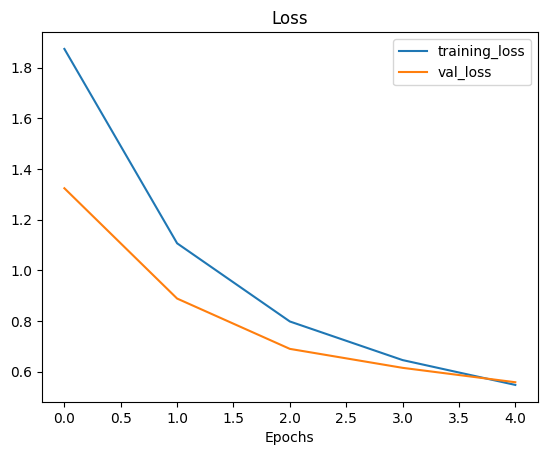

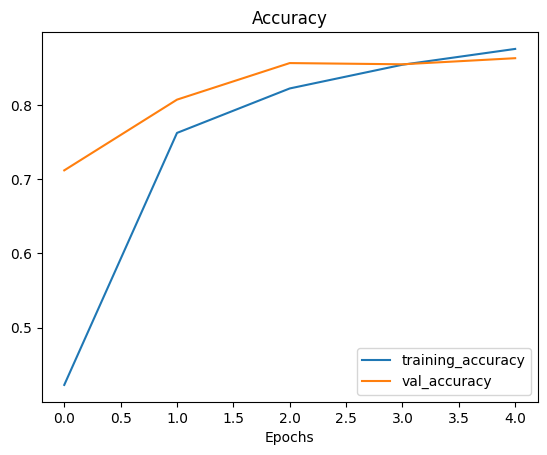

In [17]:
# Check out our models training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the global average pooling 2D layer...

We have a tensor after our model goes through `base model` of shape (None, 7, 7, 1280).

But when it passes through GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [18]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# pass the random tensor through the GlobalAveragepooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D globa averaged pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensor
print(f"Shape of the input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D globa averaged pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of the input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [19]:
# Let's replicate the GlobalAveragePooled2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data.. how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data augmentation

2. `model_2` - use feature extraction trasnfer learning with 10% of the training with data augmentation

3. `model_3` - ude fine-tuning transfer learning on 10% of the training data with data augmentation

4.  `model_4` - use fine tuning tranfer learning on 100% of the training data with augmentation.

> 🔑 Note: throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## getting and preprocessing data for `model_1`

In [20]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-08-13 17:56:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 74.125.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M  35.9MB/s    in 3.9s    

2023-08-13 17:56:30 (32.6 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [21]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [22]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'

In [23]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE,
                                                                            batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE,
                                                                            batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

The benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like resnet50v2
], name= "data_augmentation")

### Visualize our data augmentation layer

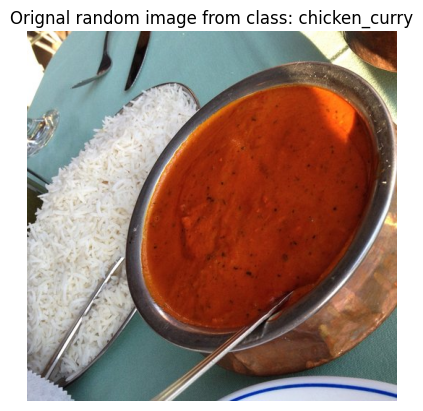

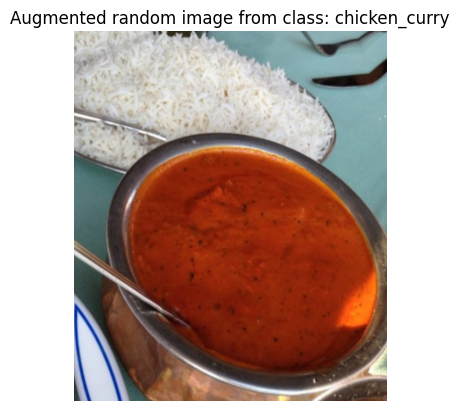

In [25]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in random image
img  = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Orignal random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0),training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [26]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a densse layer on as outputs
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs =5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=0.25*len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230813-175636
Epoch 1/5
3/3 [==============================] - 14s 4s/step - loss: 2.3934 - accuracy: 0.1286 - val_loss: 2.2036 - val_accuracy: 0.1766
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1572 - accuracy: 0.2143 - val_loss: 2.0891 - val_accuracy: 0.2562
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 1.9401 - accuracy: 0.4000 - val_loss: 1.9658 - val_accuracy: 0.3562
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7658 - accuracy: 0.5429 - val_loss: 1.8668 - val_accuracy: 0.4375
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6330 - accuracy: 0.6000 - val_loss: 1.7668 - val_accuracy: 0.4859


In [27]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [28]:
# Evaluate on the full dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 91ms/step - loss: 1.7782 - accuracy: 0.4872


[1.778218150138855, 0.487199991941452]

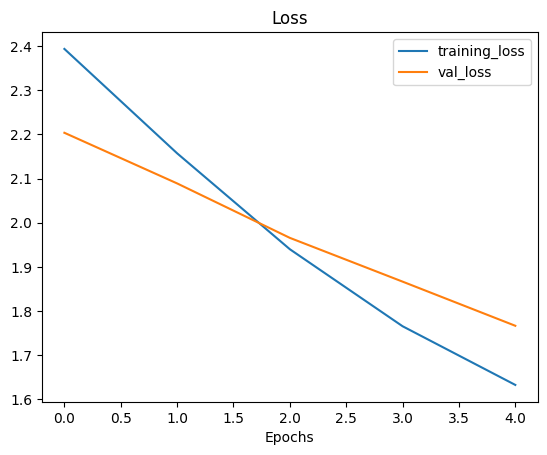

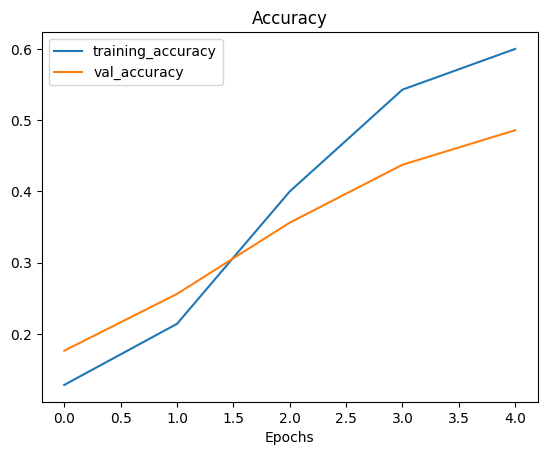

In [29]:
# How do the model with 1% of the data and data aug loss curves look like
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data

In [30]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [31]:
# set data inputs
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
],name="data_augmentation")

# Setup input to our model
input_shape = (224,224,3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layer in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training =False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

model_2 = tf.keras.Model(inputs,outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



### Creating a ModelCheckPoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can came and start where we left off

In [33]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [34]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5

history_2 = model_2.fit(train_data_10_percent,
                        epochs = initial_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                 experiment_name = "10_percent_data_aug"),checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230813-175725
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9748 - accuracy: 0.3693
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 21s 574ms/step - loss: 1.9748 - accuracy: 0.3693 - val_loss: 1.4081 - val_accuracy: 0.7237
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2854 - accuracy: 0.7147
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 450ms/step - loss: 1.2854 - accuracy: 0.7147 - val_loss: 0.9613 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9943 - accuracy: 0.7573
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 465ms/step - loss: 0.9943 - accuracy: 0.7573 - val_loss: 0.7610 - val_accuracy: 0.8388
E

In [35]:
# What were model 0 results
model_0.evaluate(test_data)

79/79 [==============================] - 9s 98ms/step - loss: 0.5577 - accuracy: 0.8608


[0.5577239990234375, 0.86080002784729]

In [36]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 72ms/step - loss: 0.6153 - accuracy: 0.8404


[0.6152943968772888, 0.840399980545044]

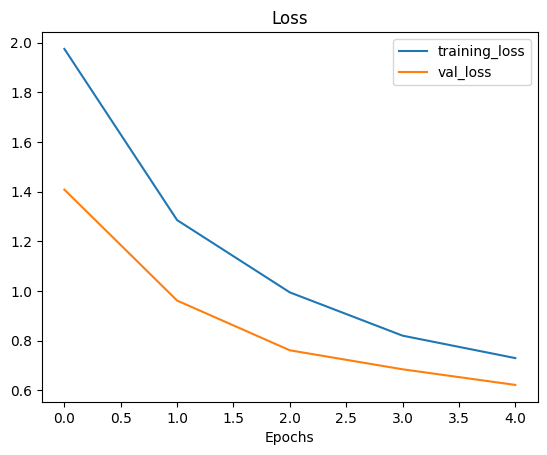

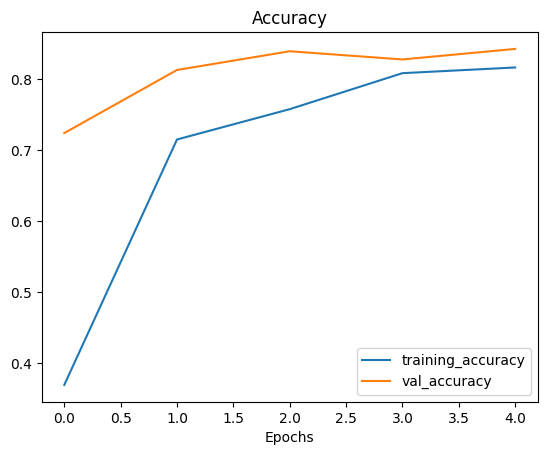

In [37]:
plot_loss_curves(history_2)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [38]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [39]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 8s 98ms/step - loss: 0.6153 - accuracy: 0.8404


In [40]:
# Check to see if loaded model results are very close to our previous non-loaded model
import numpy as np
np.isclose(np.array(loaded_weights_model_results),np.array(results_10_percent_data_aug))

array([ True,  True])

## Model 3: Fine Tuning an existing model on 10% of the data

> 🔑 **Note:** Fine-tuning usually works best after training a feature extraction of model for a few epochs with large amount of custom data

In [41]:
# Layers in our  loaded model
model_2.layers

In [42]:
# Are these model trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7b17b613ece0> True
<keras.engine.sequential.Sequential object at 0x7b17b61c7c10> True
<keras.engine.functional.Functional object at 0x7b17a2c4da80> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7b17b61c78b0> True
<keras.layers.core.dense.Dense object at 0x7b17a2cec3d0> True


In [43]:
# What are the layers in our base model (EfficientNetB0) and are they trainable
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [44]:
# How many trainable variable are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [45]:
# To begin fine tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True
# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [46]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [47]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_2.epoch[-1],# start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230813-175910
Epoch 5/10
24/24 [==============================] - 19s 507ms/step - loss: 0.6067 - accuracy: 0.8293 - val_loss: 0.4742 - val_accuracy: 0.8569
Epoch 6/10
24/24 [==============================] - 11s 452ms/step - loss: 0.5052 - accuracy: 0.8440 - val_loss: 0.4358 - val_accuracy: 0.8520
Epoch 7/10
24/24 [==============================] - 12s 486ms/step - loss: 0.4468 - accuracy: 0.8707 - val_loss: 0.4518 - val_accuracy: 0.8586
Epoch 8/10
24/24 [==============================] - 10s 398ms/step - loss: 0.3614 - accuracy: 0.8907 - val_loss: 0.4336 - val_accuracy: 0.8503
Epoch 9/10
24/24 [==============================] - 9s 357ms/step - loss: 0.3581 - accuracy: 0.8867 - val_loss: 0.4188 - val_accuracy: 0.8602
Epoch 10/10
24/24 [==============================] - 9s 338ms/step - loss: 0.3441 - accuracy: 0.9040 - val_loss: 0.4393 - val_accuracy: 0.8421


In [48]:
# Evaluate the fine tuned model
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 8s 93ms/step - loss: 0.4225 - accuracy: 0.8568


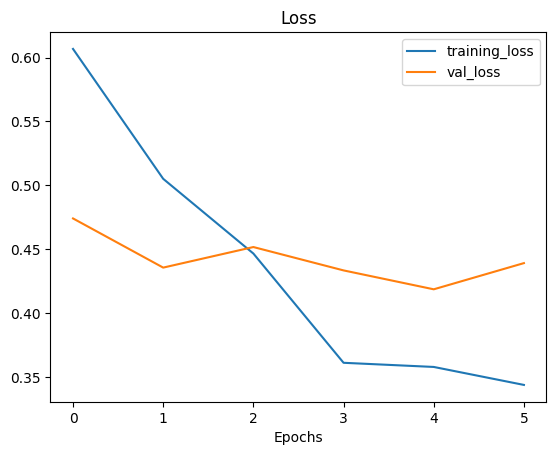

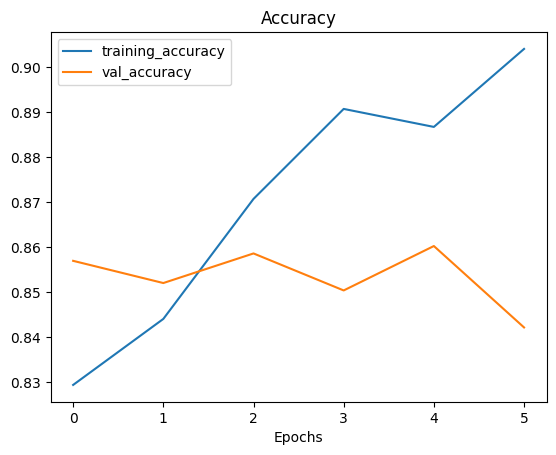

In [49]:
# Check out the loss curve of our fine tuned model

plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine tuning)

In [50]:
# let's create a function to compare training histories
def compare_history(orignal_history, new_history, initial_epochs=5):
  """
  Compares two tensorflow history objects.
  """

  # Get orignal history measurements
  acc = orignal_history.history["accuracy"]
  loss = orignal_history.history["loss"]

  val_acc = orignal_history.history["val_accuracy"]
  val_loss = orignal_history.history["val_loss"]

  # Combine orignal history
  total_acc =acc + new_history.history["accuracy"]
  total_loss =loss+ new_history.history["loss"]

  total_val_acc =val_acc + new_history.history["val_accuracy"]
  total_val_loss =val_loss + new_history.history["val_loss"]

  # Make plots
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation accuracy")

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label="Training loss")
  plt.plot(total_val_loss, label="Val loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation loss")

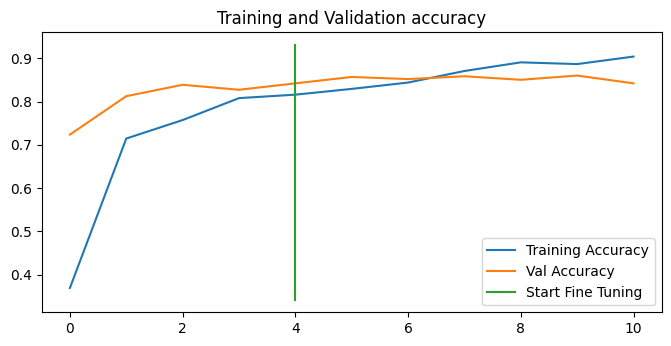

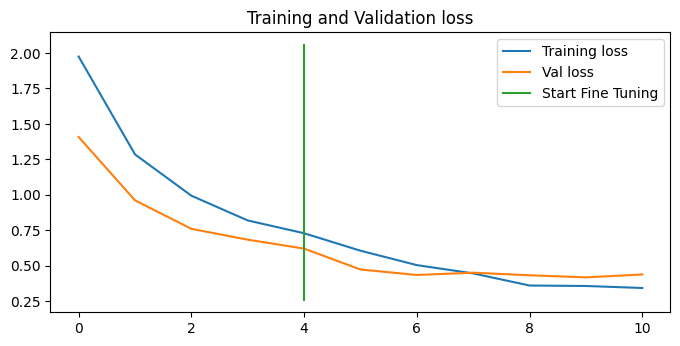

In [51]:
compare_history(history_2,history_fine_10_percent_data_aug)

## Model 4: Fine-Tuning and exisiting model on all of the data

In [52]:
# Download and unzip the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-08-13 18:00:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.2’

10_food_classes_all 100%[===================>] 495.13M  38.1MB/s    in 13s     

2023-08-13 18:00:52 (37.3 MB/s) - ‘10_food_classes_all_data.zip.2’ saved [519183241/519183241]



In [53]:
unzip_data("10_food_classes_all_data.zip")

In [54]:
# Setup training and test data
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [55]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 

In [56]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [66]:
# Load weights from checkpoint, that way we can fine tune from
# The same stage the 10 percent data model was fine tuned from
model_2.load_weights(checkpoint_path)

In [67]:
# Check which layers are trainable i the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling2d_2 True
4 output_layer True


In [68]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])


In [69]:
# Fit
fine_tune_epochs = initial_epochs + 5
history_2_100_percent_data = model_2.fit(train_data,
                                         epochs=fine_tune_epochs,
                                         validation_data = test_data,
                                         validation_steps = int(0.25*len(test_data)),
                                         initial_epoch = history_2.epoch[-1],
                                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230813-181615
Epoch 5/10
235/235 [==============================] - 90s 214ms/step - loss: 0.6605 - accuracy: 0.7895 - val_loss: 0.3579 - val_accuracy: 0.8832
Epoch 6/10
235/235 [==============================] - 47s 200ms/step - loss: 0.5279 - accuracy: 0.8288 - val_loss: 0.3275 - val_accuracy: 0.8997
Epoch 7/10
235/235 [==============================] - 47s 196ms/step - loss: 0.4677 - accuracy: 0.8480 - val_loss: 0.3235 - val_accuracy: 0.8947
Epoch 8/10
235/235 [==============================] - 45s 190ms/step - loss: 0.4267 - accuracy: 0.8621 - val_loss: 0.3242 - val_accuracy: 0.8964
Epoch 9/10
235/235 [==============================] - 41s 173ms/step - loss: 0.3825 - accuracy: 0.8771 - val_loss: 0.2949 - val_accuracy: 0.9145
Epoch 10/10
235/235 [==============================] - 44s 186ms/step - loss: 0.3630 - accuracy: 0.8840 - val_loss: 0.2770 - val_accuracy: 0.9112


In [70]:
# lets evaluate on all of the data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 11s 127ms/step - loss: 0.2648 - accuracy: 0.9124


[0.26483508944511414, 0.9124000072479248]

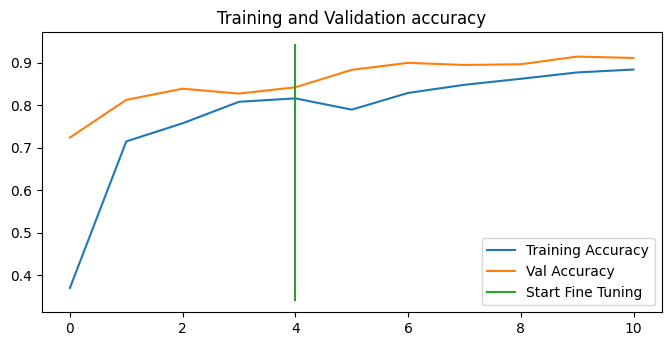

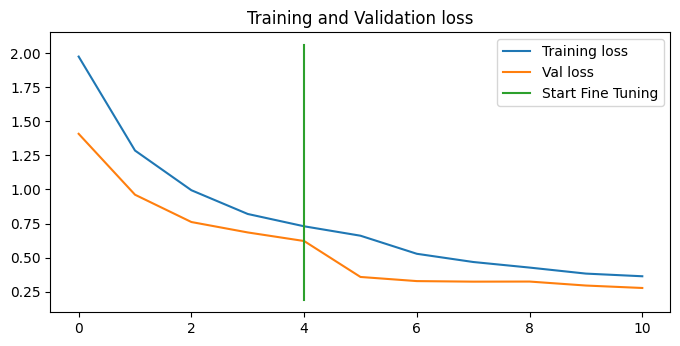

In [71]:
# How did fine-tuning go with more data
compare_history(history_2,history_2_100_percent_data)